In [150]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import altair as alt
import numpy as np

## Project and Data

This project works with data from 

Initial academic paper for data: https://arxiv.org/abs/1402.4735

In [2]:
#columns from data website
columns = ['class', 'lepton pT', 'lepton eta', 'lepton phi', 'missing energy magnitude', 'missing energy phi', 'jet 1 pt', 'jet 1 eta', 'jet 1 phi', 'jet 1 b-tag', 'jet 2 pt', 'jet 2 eta', 'jet 2 phi', 'jet 2 b-tag', 'jet 3 pt', 'jet 3 eta', 'jet 3 phi', 'jet 3 b-tag', 'jet 4 pt', 'jet 4 eta', 'jet 4 phi', 'jet 4 b-tag', 'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb']
colnames = [i.replace(' ', '_') for i in columns]

In [3]:
#getting df from csv and changing column names
df = pd.read_csv('HIGGS.csv', names = colnames, header = None)

In [4]:
#splitting df into a training and test set
train, test = train_test_split(df, test_size = 0.3, random_state = 42)

In [5]:
#function to print the number of na values for each dataframe
def num_nulls(df):
    na = df.isna().sum().sum()
    if na == 0:
        return 'No null values'
    else:
        return na
print('Train:', num_nulls(train))
print('Test:', num_nulls(test))

Train: No null values
Test: No null values


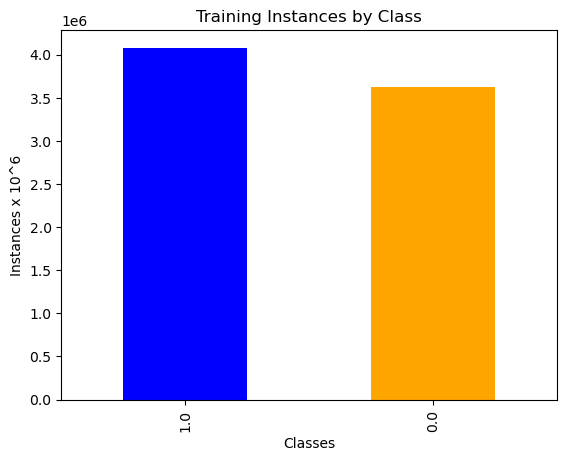

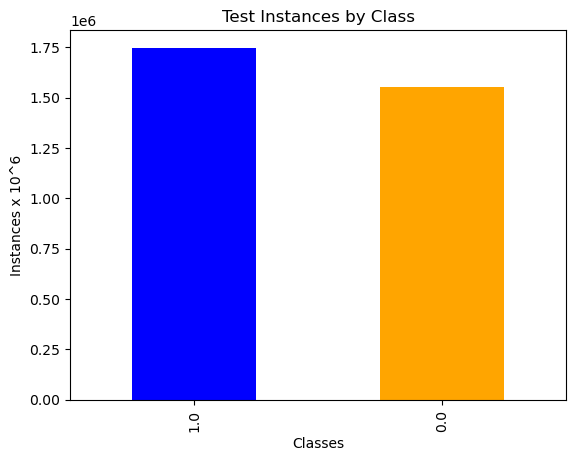

In [157]:
#Chart to show number of instances by class in training dataframe
train['class'].value_counts().plot(kind = 'bar', color = ['blue', 'orange'])
plt.title('Training Instances by Class')
plt.xlabel('Classes')
plt.ylabel('Instances x 10^6')
plt.show()
plt.clf()

#Chart to show number of instances by class in test dataframe
test['class'].value_counts().plot(kind = 'bar', color = ['blue', 'orange'])
plt.title('Test Instances by Class')
plt.xlabel('Classes')
plt.ylabel('Instances x 10^6')
plt.show()

In [340]:
#Getting column names of df's and setting as list
medians_cols = list(train.columns)
#getting the median values for each feature depending on the class target
one_medians = train[train['class'] == 1.0].median().values
one_medians = pd.Series(one_medians)
one_medians.index = medians_cols
zero_medians = train[train['class'] == 0].median().values
zero_medians = pd.Series(zero_medians)
zero_medians.index = medians_cols
#getting std values for each feature depending on the class target
ones_sd = np.std(train[train['class'] == 1])
zeros_sd = np.std(train[train['class'] == 0])


#creating four empty lists which will be filled with median values +- 1.96 std 
max_vals_one = []
min_vals_one = []
max_vals_zero = []
min_vals_zero = []

#function that utilizes standard deviation and median values and adds +- 1.96 std
def sd_3(sd, median, val, val_list):
    #meaning we want to add 1.96 sd
    if val == 'max':
        for i in range(sd.shape[0]):
            #add to appropriate list
            val_list.append(median.iloc[i] + (1.96 * sd.iloc[i]))
    #subtracting 1.96sd
    else:
        for i in range(sd.shape[0]):
            val_list.append(median.iloc[i] - (1.96 * sd.iloc[i]))
            
#running function four times so as to fill our four empty lists
sd_3(ones_sd, one_medians, 'max', max_vals_one)
sd_3(ones_sd, one_medians, 'min', min_vals_one)
sd_3(zeros_sd, zero_medians, 'max', max_vals_zero)
sd_3(zeros_sd, zero_medians, 'min', min_vals_zero);

#function to convert list to pd Series and to set the index to be the feature names of original dataset
def list_series(list):
    series = pd.Series(list)
    series.index = medians_cols
    return series
#running each of four lists into function to become series
max_vals_one = list_series(max_vals_one)
min_vals_one = list_series(min_vals_one)
max_vals_zero = list_series(max_vals_zero)
min_vals_zero = list_series(min_vals_zero);

#combining median values and max_min for each class into a single dataframe
df_format = pd.concat([one_medians, zero_medians, max_vals_one, min_vals_one, max_vals_zero, min_vals_zero], 
                      axis = 1)
#dropping the row for class since this provides no meaningful information
df_format = df_format.drop('class', axis=0)
#reset index and adding 'index' column for charting with altair
df_format = df_format.reset_index()
#renaming columns to descriptive title and to string for charting with altair
df_format = df_format.rename(columns = {
    0: 'one_median', 1: 'zero_median', 2: 'one_max', 3: 'one_min', 4: 'zero_max', 5: 'zero_min'
})

In [338]:
### Altair Chart

#adding selection so that when mouse hovers over value that value is selected
selection = alt.selection(type='multi', fields=['index'], on='mouseover', nearest=True)

#creating chart for all data associated with class of 1
ones = alt.Chart(df_format).mark_point(filled = True, size = 80).encode(
    alt.X('index:N', title = 'Features'),
    alt.Y('one_median:Q', title = 'Feature Measures'),
    #setting color scheme
    color = alt.Color('index', scale = alt.Scale(scheme = 'tableau20')),
    #setting option so that data not selected on mouseover becomes more transparent
    opacity=alt.condition(selection, alt.value(1), alt.value(.2)),
    #when selecting data point, tooltip shows values associated each col
    tooltip = ['index', 'one_median', 'one_max', 'one_min']
).interactive().properties(height = 200, title = 'Features for Class One').add_selection(selection)

#creating error bars for 1.96 sd +- median value
error_bars = ones.mark_errorbar(size = 80).encode(
    x = 'index',
    y = 'one_max:Q',
    y2 = 'one_min:Q'
)

#utilizing the same mechanism as above, but this time utilizing for values of class 0
zero = alt.Chart(df_format).mark_point(filled = True, size = 80).encode(
    alt.X('index:N', title = 'Features'),
    alt.Y('one_median:Q', title = 'Feature Measures'),
    color = alt.Color('index', scale = alt.Scale(scheme = 'tableau20')),
    opacity=alt.condition(selection, alt.value(1), alt.value(.2)),  
    tooltip = ['index', 'zero_median', 'zero_max', 'zero_min']
).interactive().properties(height = 200, title = 'Features for Class Zero').add_selection(selection)

error_bars_zero = zero.mark_errorbar(size = 80).encode(
    x = 'index',
    y = 'zero_max:Q',
    y2 = 'zero_min:Q'
)

#plotting each chart with its error bars charts stacked, so that they can be viewed concurrently
(ones + error_bars) & (zero + error_bars_zero)

alt.VConcatChart(...)